In [1]:
import tensorflow as tf

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [4]:
tf.__version__

'2.0.0'

In [5]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 21s 0us/step


In [6]:
data_dir

PosixPath('/home/flyinstinct/.keras/datasets/flower_photos')

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [8]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['sunflowers', 'tulips', 'dandelion', 'roses', 'daisy'],
      dtype='<U10')

In [9]:
!ls {data_dir}

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


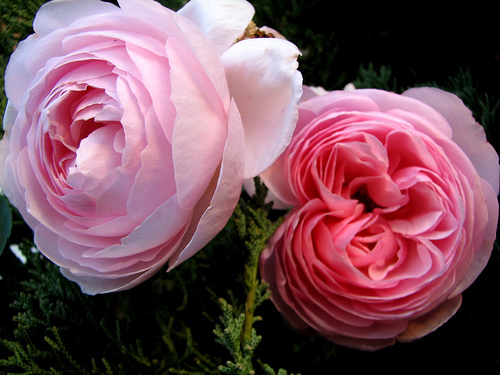

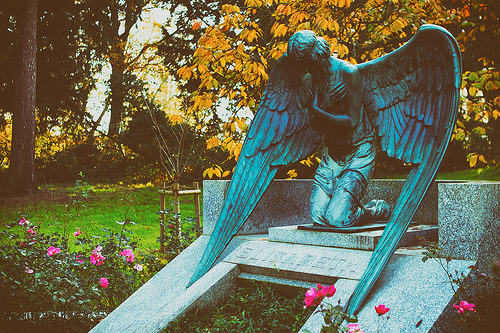

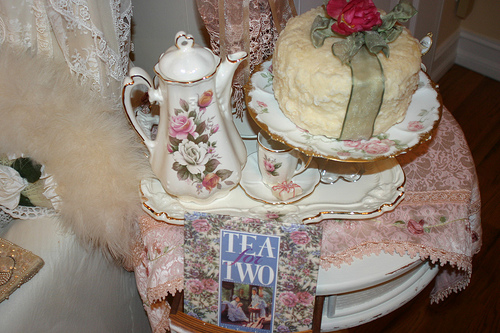

In [10]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

In [11]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [12]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [13]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [14]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

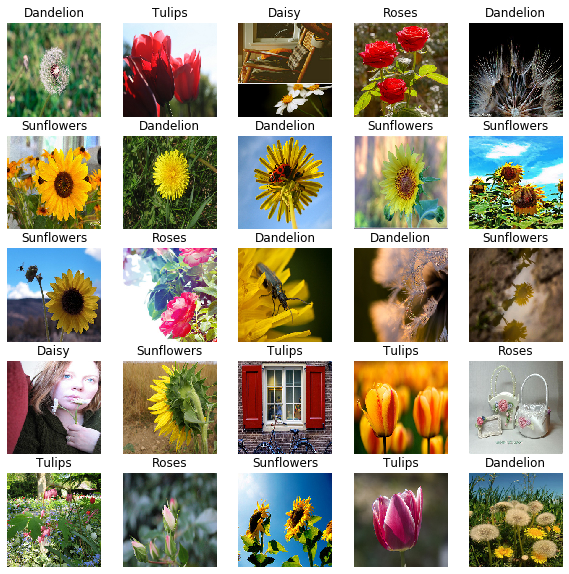

In [15]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [16]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [18]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/flyinstinct/.keras/datasets/flower_photos/tulips/14068200854_5c13668df9_m.jpg'
b'/home/flyinstinct/.keras/datasets/flower_photos/tulips/130685347_afbffe3afa_n.jpg'
b'/home/flyinstinct/.keras/datasets/flower_photos/daisy/5110107234_12ddc0206b_m.jpg'
b'/home/flyinstinct/.keras/datasets/flower_photos/tulips/12916017805_1cde91a891_n.jpg'
b'/home/flyinstinct/.keras/datasets/flower_photos/tulips/2436998042_4906ea07af.jpg'


In [19]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, '/')
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [20]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [22]:
2 == np.array([1,2,3,4,5])

array([False,  True, False, False, False])

In [23]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [24]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False  True False]


In [26]:


def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [27]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

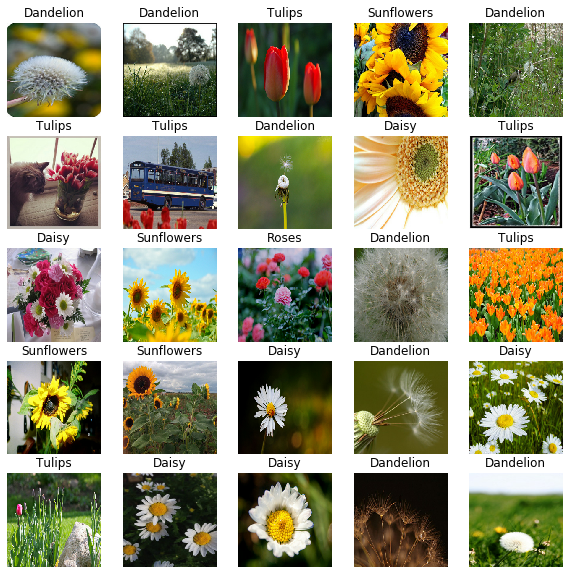

In [28]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [29]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [30]:
timeit(train_data_gen)

....................................................................................................
1000 batches: 44.269580364227295 s
722.84399 Images/s


In [31]:
timeit(train_ds)

....................................................................................................
1000 batches: 4.390575647354126 s
7288.33815 Images/s


In [32]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

....................................................................................................
1000 batches: 19.91157865524292 s
1607.10512 Images/s


In [33]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

....................................................................................................
1000 batches: 12.38614273071289 s
2583.53231 Images/s


In [35]:
labeled_ds

<DatasetV1Adapter shapes: ((224, 224, 3), (5,)), types: (tf.float32, tf.bool)>

In [36]:
list_ds

<DatasetV1Adapter shapes: (), types: tf.string>

In [38]:
list_ds.dtype

AttributeError: 'DatasetV1Adapter' object has no attribute 'dtype'